In [1]:
%matplotlib inline
%reset
#%pylab inline
import xarray as xr
import numpy as np
import datetime as dati
import parcels
import netCDF4
import matplotlib
from matplotlib import pylab
from parcels import FieldSet, Field, Variable, Field
from parcels import ParticleSet, ScipyParticle, JITParticle, AdvectionRK4_3D, AdvectionRK4
from parcels import FieldSamplingError, ParticleFile, plotTrajectoriesFile

path = "E:\\OceanParcels"

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


ImportError: cannot import name 'ErrorCode' from 'parcels' (C:\ProgramData\anaconda3\envs\parcels_env\Lib\site-packages\parcels\__init__.py)

# Reindexing

In [9]:
in_name = path + "\\data\\raw\\out_small_2022-05.nc"
df = xr.open_dataset(in_name, decode_times = False).load()
df.close()
# print(np.nanmin(df.botz.values), np.nanmax(df.botz.values))
# print(np.nanmin(df.x_grid.values), np.nanmax(df.x_grid.values))
# print(np.nanmin(df.y_grid.values), np.nanmax(df.y_grid.values))
df

-41.4925 -31.58
147.525959 147.578831
-43.120533 -43.082305


<xarray.Dataset>
Dimensions:   (k_grid: 25, k_centre: 24, j_grid: 43, i_grid: 44, j_centre: 42,
               i_centre: 43, j_left: 42, i_left: 44, j_back: 43, i_back: 43,
               record: 4464)
Dimensions without coordinates: k_grid, k_centre, j_grid, i_grid, j_centre,
                                i_centre, j_left, i_left, j_back, i_back, record
Data variables: (12/47)
    z_grid    (k_grid) float64 -50.0 -47.0 -42.0 -37.0 ... -0.2 0.0 0.2 1e+20
    z_centre  (k_centre) float64 -48.5 -44.5 -39.5 -34.5 ... -0.35 -0.1 0.1 0.35
    x_grid    (j_grid, i_grid) float64 147.6 147.6 147.6 ... 147.5 147.5 147.5
    y_grid    (j_grid, i_grid) float64 -43.12 -43.12 -43.12 ... -43.08 -43.08
    x_centre  (j_centre, i_centre) float64 147.6 147.6 147.6 ... 147.5 147.5
    y_centre  (j_centre, i_centre) float64 -43.12 -43.12 ... -43.08 -43.08
    ...        ...
    w         (record, k_centre, j_centre, i_centre) float32 0.0 ... -5.856e-05
    eta       (record, j_centre, i_centre) float32 0.01205 0.008019 ... 0.3316
    salt      (record, k_centre, j_centre, i_centre) float32 nan nan ... 34.3
    temp      (record, k_centre, j_centre, i_centre) float32 nan nan ... 12.85
    u1av      (record, j_left, i_left) float32 0.001326 0.001544 ... -0.01435
    u2av      (record, j_back, i_back) float32 -0.04973 -0.04967 ... -0.06819
Attributes: (12/17)
    title:         SHOC grid
    codehead:      SHOC default version
    paramhead:     13 RunName: IMTA_RUN
    description:   Automated grid from auto.prm
    paramfile:     /datasets/work/oa-etas/work/RECOM4SCOTT/sb-recom-runs/13.n...
    ems_version:   v1.4.0 rev(6965M)
    ...            ...
    nce2:          42
    nfe1:          44
    nfe2:          43
    ns3:           40030
    ns2:           1892
    gridtype:      NUMERICAL

From the NEMO tutorial: Note that NEMO is discretised on a C-grid. U and V velocities are not located on the same nodes (see https://www.nemo-ocean.eu/doc/node19.html). To interpolate U, V velocities on the C-grid, Parcels needs to read the f-nodes, which are located on the corners of the cells (for indexing details: https://www.nemo-ocean.eu/doc/img360.png, https://docs.oceanparcels.org/en/latest/examples/documentation_indexing.html#NEMO-Example).

According to that last link, NEMO is indexed as:
```
 __V0__.f0
|      |
|      U0
|______|
```
Where i and j are increasing in the horizontal and vertical directions respectively. Converting those two points to SHOC would become: NEMO_U[i,j] = SHOC_U[i+1,j] and NEMO_V[i,j] = SHOC_V[i,j+1]. At the same time, SHOC provides a bit more grid information, the depths are flipped, and a few other transformations are needed.

### Coordinates grid

In the NEMO files, latitude and longitude are stored in a seperate file BUT are both 3D (time dimension, with size=1). Depth is stored seperately and is 1D. The data is 4D. It's not really necessary to have a seperate coordinates file but it might save some memory.

In [1]:
in_name = path + "\\data\\raw\\out_small_2022-05.nc"
out_name = path + "\\data\\processed\\coordinates.nc"

df = xr.open_dataset(in_name, decode_times = False).load()
# This is where U, V and W are currently indexed from
#x_centre = df.x_centre.values[0, :]
#y_centre = df.y_centre.values[:, 0]
#z_centre = np.flip(df.z_centre.values)

# This is where f-nodes come from
x_grid = df.x_grid.values[0, :]
y_grid = df.y_grid.values[:, 0]
z_grid = np.flip(df.z_grid.values)
botz = df.botz.values

# Where parcels wants U, V and W measured
x_grid = x_grid[1:]
y_grid = y_grid[1:]
z_grid = z_grid[1:]
cells_i = sum(np.shape(x_grid))
cells_j = sum(np.shape(y_grid))

# Clip depth
z_grid = z_grid[1:]*-1
z_grid[0] = 0
cells_k = sum(np.shape(z_grid))
z_grid = z_grid[0:cells_k-1]
cells_k = sum(np.shape(z_grid))
print(z_grid)    

# MAKE THEM GRIDS
lat_grid = np.repeat(y_grid[:, np.newaxis], cells_i, axis = 1).astype('float32')
lon_grid = np.repeat(x_grid[np.newaxis, :], cells_j, axis = 0).astype('float32')

dep_grid = np.repeat(z_grid[:, np.newaxis], cells_j, axis = 1)
dep_grid = np.repeat(dep_grid[:, :, np.newaxis], cells_i, axis = 2).astype('float32')

ds_coords = xr.Dataset(data_vars = {'lat_grid': (['j','i'], lat_grid),
                                    'lon_grid': (['j','i'], lon_grid),
                                    'dep_grid': (['k','j','i'], dep_grid),
                                    'botz': (['j','i'], botz)})

ds_coords.dep_grid.attrs = {'long_name': 'Vertical depth', 'units': 'm', 'positive': 'down'}
ds_coords.lat_grid.attrs = {'long_name': 'Latitude', 'units': 'degrees_north'}
ds_coords.lon_grid.attrs = {'long_name': 'Longitude', 'units': 'degrees_east'}
ds_coords.botz.attrs = {'long_name': 'Depth of the benthos', 'units': 'm'}

xr.set_options(keep_attrs = True)
ds_coords.to_netcdf(out_name)

df.close()

NameError: name 'path' is not defined

In [ ]:
mon1 = np.array(['05', '06', '07', '08', '09', '10'])
mon2 = np.array(['may', 'jun', 'jul', 'aug', 'sep', 'oct'])
days1 = np.array([4464, 4320, 4464, 4464, 4320, 4464])
days2 = np.array([31, 30, 31, 31, 30, 31])
min10 = dati.timedelta(minutes = 10).total_seconds()

for mo in range(0,6):
    in_name = path + "\\data\\raw\\out_small_2022-" + mon1[mo] + ".nc"
    out_name = path + "\\data\\raw\\reindexed_" + mon2[mo] + ".nc"
    
    df = xr.open_dataset(in_name, decode_times = False).load()
        
    times = df.t.values
    tt = sum(np.shape(times))

    if mo == 0:
        start_t = 0
        dd = days2[mo].astype('float')
        end_t = dati.timedelta(days = dd).total_seconds() - min10
    else:
        dd = np.sum(days2[:(mo-1)]).astype('float')
        start_t = dati.timedelta(days = dd).total_seconds()
        dd = np.sum(days2[:mo]).astype('float')
        end_t = dati.timedelta(days = dd).total_seconds() - min10

    times_secs = np.linspace(start = start_t, num = tt, stop = end_t)

    U = df.u1.values
    V = df.u2.values
    W = df.w.values
    Uav = df.u1av.values
    Vav = df.u2av.values

    cells_i = sum(np.shape(np.squeeze(W[0,0,0,:])))
    cells_j = sum(np.shape(np.squeeze(W[0,0,:,0])))
    cells_k = sum(np.shape(np.squeeze(W[0,:,0,0])))-2

    # Fixes horizontal indexing (W is already correct)
    U = U[:, :, :cells_j, :cells_i]
    V = V[:, :, :cells_j, :cells_i]
    Uav = Uav[:, :cells_j, :cells_i]
    Vav = Vav[:, :cells_j, :cells_i]

    # Flip for depth - make sure depth is on axis 1!
    U = np.flip(U, axis = 1)
    V = np.flip(V, axis = 1)
    W = np.flip(W, axis = 1)

    # Clip to match coordinates
    U = U[:, 0:cells_k, :, :]
    V = V[:, 0:cells_k, :, :]
    W = W[:, 1:(cells_k+1), :, :]

    ds = xr.Dataset(data_vars = {"U": (['t', 'k', 'j', 'i'], U.astype('float32')),
                                 "V": (['t', 'k', 'j', 'i'], V.astype('float32')),
                                 "W": (['t', 'k', 'j', 'i'], W.astype('float32')),
                                 "Uav": (['t', 'j', 'i'], Uav.astype('float32')),
                                 "Vav": (['t', 'j', 'i'], Vav.astype('float32'))},
                    coords = {"times": ('t', times),
                              "times_secs": ('t', times_secs)})

    xr.set_options(keep_attrs = True)
    ds.to_netcdf(out_name)
    
    df.close()

### Grid types

Parcels automatically picks your grid type based on data structure, which doesn't necessarily match the actual grid. Of course, if you have U, V and W data over time then the grid is always 4D. Here are the possible structural types:

1. 1D lat, lon, depth and time arrays == Rectilinear Z Grid
2. 2D lat and lon arrays and 1D depth and time arrays == Curvilinear Z Grid
3. 2D lat and lon arrays, a 3D depth array and a 1D time array == Curvilinear S Grid

Results coming from SHOC chould be on a Curvilinear S Grid.

In [2]:
datafile = path + "\\data\\raw\\reindexed_" + 'jun' + ".nc"
coords = path + "\\data\\coordinates.nc"

with xr.open_dataset(coords) as cs:
    lon_grid = cs.lon_grid.values
    lat_grid = cs.lat_grid.values
    dep_grid = cs.dep_grid.values
with xr.open_dataset(datafile) as ds:
    times =  ds.times_secs.values # use "times", or use "times_secs" if getting lots of ns_date errors messing with outputs
    U = ds.U.values
    V = ds.V.values
    W = ds.W.values

dims = {'U': {'lon': lon_grid, 'lat': lat_grid, 'time': times, 'depth': dep_grid},
        'V': {'lon': lon_grid, 'lat': lat_grid, 'time': times, 'depth': dep_grid},
        'W': {'lon': lon_grid, 'lat': lat_grid, 'time': times, 'depth': dep_grid},}

fset = FieldSet.from_data(data = {'U': U, 'V': V, 'W': W},
                          dimensions = dims,
                          #timestamps = [ds.times.values],
                          gridindexingtype = 'nemo')

print("You have created a fieldset with grid type: %s" %fset.W.grid.gtype)

You have created a fieldset with grid type: GridCode.CurvilinearSGrid


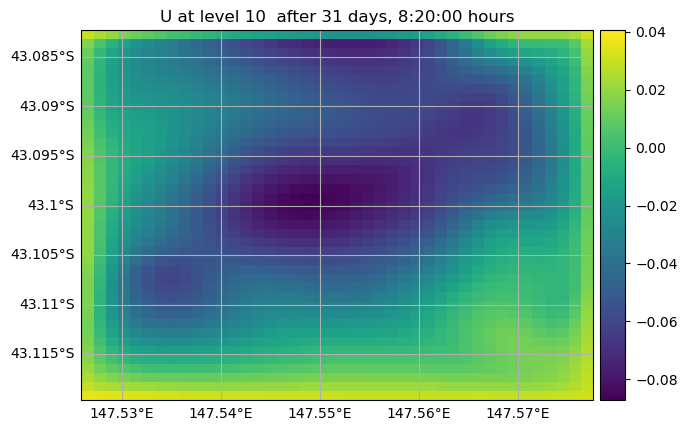

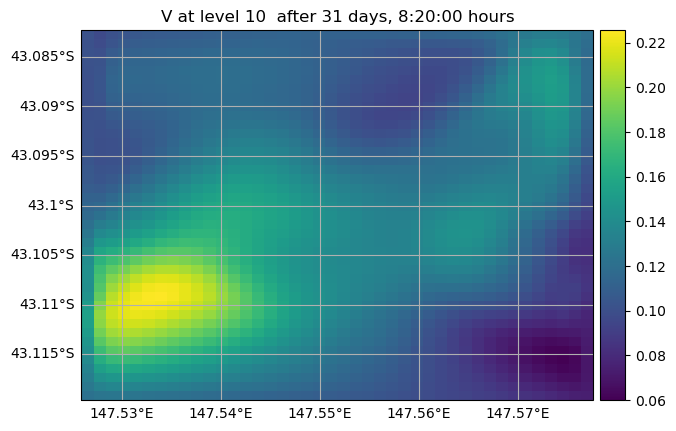

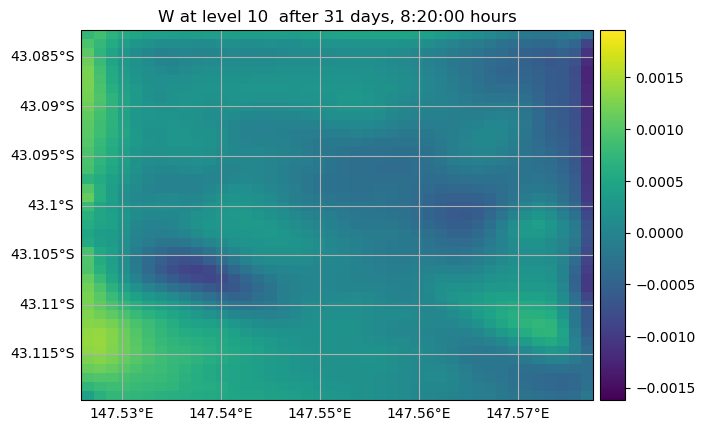

In [3]:
fset.U.show(show_time = fset.U.grid.time_full[50], depth_level = 10)
fset.V.show(show_time = fset.V.grid.time_full[50], depth_level = 10)
fset.W.show(show_time = fset.W.grid.time_full[50], depth_level = 10)

Particles repeating every 36000.000000 seconds
P[105](lon=147.556229, lat=-43.097496, depth=6.636138, time=0.000000)
P[106](lon=147.563370, lat=-43.091923, depth=3.321431, time=0.000000)
P[107](lon=147.544846, lat=-43.107723, depth=6.119771, time=0.000000)
P[108](lon=147.549652, lat=-43.105682, depth=41.978279, time=0.000000)
P[109](lon=147.538101, lat=-43.102104, depth=12.610534, time=0.000000)
P[110](lon=147.534637, lat=-43.111443, depth=4.661297, time=0.000000)
P[111](lon=147.564926, lat=-43.111515, depth=1.905930, time=0.000000)
P[112](lon=147.555984, lat=-43.111805, depth=36.946747, time=0.000000)
P[113](lon=147.549850, lat=-43.085812, depth=34.810909, time=0.000000)
P[114](lon=147.573517, lat=-43.114204, depth=14.549070, time=0.000000)
P[115](lon=147.550171, lat=-43.116276, depth=19.780615, time=0.000000)
P[116](lon=147.557983, lat=-43.087719, depth=18.619486, time=0.000000)
P[117](lon=147.532898, lat=-43.106537, depth=10.966296, time=0.000000)
P[118](lon=147.569870, lat=-43.0953

type: U sampled outside time domain at time 0.0. Try setting allow_time_extrapolation to True

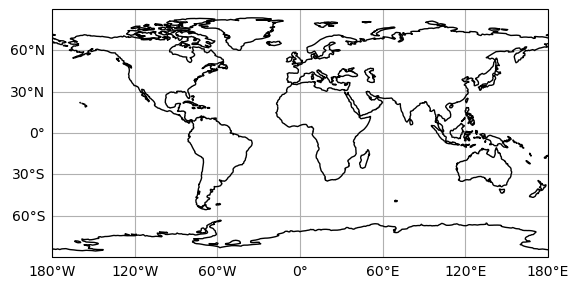

In [14]:
npart = 15
lon_range = (fset.U.grid.lon[2,2], fset.U.grid.lon[40,40])
lat_range = (fset.U.grid.lat[2,2], fset.U.grid.lat[39,39])
dep_range = (fset.U.grid.depth[2,0,0], fset.U.grid.depth[20,0,0])

pset = ParticleSet.from_list(fieldset = fset,
                             pclass = JITParticle, 
                             # particles populate randomly within set ranges
                             lon = np.random.uniform(*lon_range, size = (npart, )),
                             lat = np.random.uniform(*lat_range, size = (npart, )),
                             depth = np.random.uniform(*dep_range, size = (npart, )),
                             # first particles populate at time 0
                             time = np.zeros(npart), #*dati.timedelta(minutes=30).total_seconds(),
                             # particles repopulate in same positions every ten hours
                             repeatdt = dati.timedelta(hours = 10).total_seconds()
                            )

pset.populate_indices()
print("Particles repeating every %f seconds" %pset.repeatdt)
print(pset)
pset.show(field = fset.U, depth_level = 5, show_time = dati.timedelta(minutes = 1))

In [15]:
def DeleteParticle(particle, fieldset, time):
    print("Particle %d deleted at (%f, %f, %f)" % (particle.id, particle.lon, particle.lat, particle.depth))
    particle.delete() # Deletes particle if it's out of bounds

kernels = pset.Kernel(AdvectionRK4_3D)

In [16]:
outname = path + "\\outputs\\testing\\grid_testing_30mins.zarr"
outfile = pset.ParticleFile(name = outname, 
                            outputdt = dati.timedelta(minutes = 30))
pset.execute(kernels, 
             output_file = outfile,
             runtime = dati.timedelta(days = 1), 
             dt = dati.timedelta(minutes = 30),
             recovery = {ErrorCode.ErrorOutOfBounds: DeleteParticle})

type: OSError during compilation. Please check if compiler exists: gcc

In [ ]:
plotTrajectoriesFile(outname, mode = "3d")

In [ ]:
plotTrajectoriesFile(outname, mode = "movie2d_notebook")